In [670]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
import pybaselines
from sklearn.preprocessing import normalize as norm

In [671]:
FILE_PATH = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0001.root" #Relative file path
file1 = uproot.open(FILE_PATH)
file1["tree"].show()

FILE_PATH_2 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0002.root" #Relative file path
file2 = uproot.open(FILE_PATH_2)

FILE_PATH_3 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0003.root" #Relative file path
file3 = uproot.open(FILE_PATH_3)

FILE_PATH_4 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0004.root" #Relative file path
file4 = uproot.open(FILE_PATH_4)

FILE_PATH_5 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0005.root" #Relative file path
file5 = uproot.open(FILE_PATH_5)

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [672]:
print(type(file1["tree"]["base"].array()))
bl=file1["tree"]["base"].array()
print(ak.num(bl))
#bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

nch=file1["tree"]["ch"].array()
print(nch)

<class 'awkward.highlevel.Array'>
[16, 16, 16, 16, 16, 16, 16, 16, 16, ..., 16, 16, 16, 16, 16, 16, 16, 16, 16]
[16]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 15]]


In [673]:
import numpy as np

def extract_data(file):
    baselines = np.array(file["tree"]["base"])[1:-1]
    charges = np.array(file["tree"]["charge"])[1:-1]
    amp = np.array(file["tree"]["amp"])[1:-1]
    lead_edge = np.array(file["tree"]["letime"])[1:-1]
    t_edge = np.array(file["tree"]["tetime"])[1:-1]
    channel = np.array(file["tree"]["ch"])[1:-1]
    waveform = np.array(file["tree"]["pshape"])[1:-1]
    
    return baselines, charges, amp, lead_edge, t_edge, channel, waveform

# Use the function for each batch
baselines1, charges1, amp1, lead_edge1, t_edge1, channel1, waveform1 = extract_data(file1)
baselines2, charges2, amp2, lead_edge2, t_edge2, channel2, waveform2 = extract_data(file2)
baselines3, charges3, amp3, lead_edge3, t_edge3, channel3, waveform3 = extract_data(file3)
baselines4, charges4, amp4, lead_edge4, t_edge4, channel4, waveform4 = extract_data(file4)
baselines5, charges5, amp5, lead_edge5, t_edge5, channel5, waveform5 = extract_data(file5)

#concatenate arrays

baselines=np.concatenate((baselines1, baselines2, baselines3, baselines4, baselines5))
charges = np.concatenate((charges1, charges2, charges3, charges4, charges5))
amp = np.concatenate((amp1, amp2, amp3, amp4, amp5))
lead_edge = np.concatenate((lead_edge1, lead_edge2, lead_edge3, lead_edge4, lead_edge5))
t_edge = np.concatenate((t_edge1, t_edge2, t_edge3, t_edge4, t_edge5))
channel = np.concatenate((channel1, channel2, channel3, channel4, channel5))
waveform = np.concatenate((waveform1, waveform2, waveform3, waveform4, waveform5))


In [674]:
#carico la matrice degli offset
def load_matrix(filename):
    return(np.load(filename))

loaded=load_matrix('offset_matrix.npz')
matrix_loaded = loaded['arr_0']
print(matrix_loaded)

[[ 0.          1.50500943  7.62525845  4.61293362  3.15892701  0.42782056
   4.49672154  1.77843779  2.40697245  0.59281318 -0.90675317  1.68751028
   5.71198922  0.          4.56768762  0.97792598]
 [-1.50500943  0.          6.11065928  2.85206175  1.13653755 -2.20474312
   2.46788101  0.51116414  0.80656163 -0.85936461 -2.18658085 -1.00696636
   3.23813492  0.          3.03523668 -0.19754189]
 [-7.62525845 -6.11065928  0.         -3.3739286  -5.72502314 -8.24391322
  -3.54354023 -6.27318018 -4.97360872 -7.1802282  -8.55086201 -6.64136498
  -2.35827787  0.         -3.72766191 -6.57743136]
 [-4.61293362 -2.85206175  3.3739286   0.         -1.37643551 -4.76837872
   0.20964947 -2.70117638 -2.30973294 -4.06801263 -5.26312062 -2.77706457
   1.03675632  0.         -0.21015299 -3.23818714]
 [-3.15892701 -1.13653755  5.72502314  1.37643551  0.         -3.05462833
   1.55270473 -1.13492494 -1.03074154 -2.32552449 -3.62794031 -1.61582009
   2.22239742  0.          1.26570009 -1.43924862]
 [-0.

In [675]:
print(amp.shape)
print(charges.shape)
print(len(amp))

(23856,)
(23856,)
23856


In [676]:
len(np.where(amp[0]>-1.2)[0])==16

True

In [677]:
print(channel)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 ...
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)                                                     ]


In [678]:

mask=[len(np.where(amp[i]>-1.2)[0])==16 for i in range(len(amp))]
print(mask)
baselines=baselines[mask]
charges=charges[mask]
amp=amp[mask]
lead_edge=lead_edge[mask]
t_edge=t_edge[mask]
channel=channel[mask]
waveform=waveform[mask]

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, False, True, False, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, Tru

In [679]:
print(len(amp))
Nev=len(amp)

18853


(18853,)
channel: 0 baseline: 3.8e-05 charge -1.476 lead_edge 217.541 trailing_edge 214.692
channel: 1 baseline: 0.000457 charge -118.43 lead_edge 324.118 trailing_edge 268.401
channel: 2 baseline: 7.6e-05 charge -3232.223 lead_edge 415.86 trailing_edge -0.009
channel: 3 baseline: -0.000191 charge -1.327 lead_edge 201.895 trailing_edge 197.599
channel: 4 baseline: -3.8e-05 charge 2.797 lead_edge 81.484 trailing_edge 80.813
channel: 5 baseline: 0.000229 charge -0.761 lead_edge 204.706 trailing_edge 200.409
channel: 6 baseline: -0.000229 charge 0.721 lead_edge 224.261 trailing_edge 220.125
channel: 7 baseline: -3.8e-05 charge 0.658 lead_edge 201.802 trailing_edge 197.801
channel: 8 baseline: 0.000343 charge -0.601 lead_edge 210.195 trailing_edge 205.37
channel: 9 baseline: -0.000191 charge 1.853 lead_edge 204.682 trailing_edge 203.235
channel: 10 baseline: -0.008235 charge -0.023 lead_edge 333.178 trailing_edge 329.832
channel: 11 baseline: 0.0 charge -0.784 lead_edge 103.687 trailing_ed

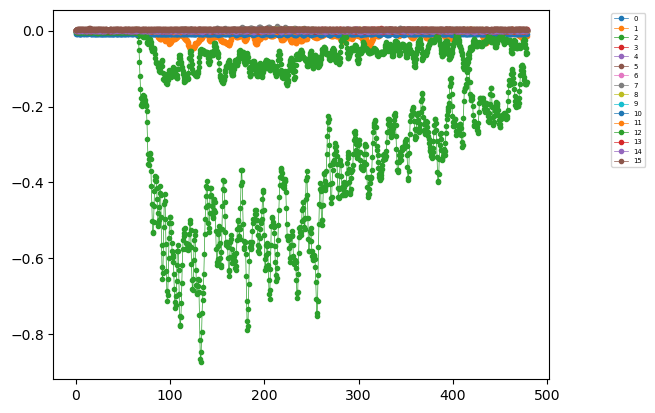

In [680]:
print(waveform.shape)
event=285
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#list=[1,2,7,12]
sampling=0.468
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    #print(t1,t2)
    #plt.scatter( t1, waveform[event][channel][int(t1/sampling)],s=60   )
    #plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60  )
    #plt.xlim(400,600)
    #plt.ylim(-0.01, 0.1)

plt.legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))

In [681]:
###pulizia
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
true_charges=[]
true_amps=[]
true_channels=[]
true_waveforms=[]
true_ledge=[]
for ev in range(Nev):
    interesting_channels=np.where(charges[ev]<-50)[0] #canali che hanno visto qualcosa
    true_channels.append(interesting_channels.tolist())
    true_charges.append([charges[ev][ch] for ch in interesting_channels])
    true_amps.append([amp[ev][ch] for ch in interesting_channels])
    true_waveforms.append([waveform[ev][ch] for ch in interesting_channels])
    true_ledge.append([lead_edge[ev][ch] for ch in interesting_channels])


#print(true_channels)
#print(true_charges)


#devo selezionare le annichilazioni back to back e isolarle dal resto


In [682]:
#eventi con 3 gamma
n_photons=[len(true_channels[i]) for i in range(Nev)]
n_photons=np.array(n_photons)
three_gamma_events=np.where(n_photons == 4)[0] #eventi con 4 fotoni totali (ortopositronio?)
print(three_gamma_events)
four_gamma_events=np.where(n_photons == 5)[0]
print(four_gamma_events)

[   16    23    29    60    86   149   158   176   211   213   214   225
   235   236   253   263   275   278   292   367   378   387   410   412
   434   442   449   518   575   594   598   620   627   705   738   769
   774   781   792   811   831   842   849   852   886   895   917   932
   963  1005  1035  1049  1055  1056  1058  1074  1086  1102  1118  1119
  1159  1164  1191  1201  1223  1242  1257  1295  1306  1313  1322  1327
  1349  1359  1384  1386  1398  1407  1417  1418  1439  1444  1497  1513
  1516  1536  1591  1594  1617  1621  1635  1668  1676  1686  1688  1693
  1729  1758  1770  1774  1799  1829  1848  1857  1862  1901  1903  1931
  1933  1958  2013  2018  2034  2093  2105  2124  2127  2139  2154  2232
  2276  2321  2324  2359  2404  2472  2478  2551  2554  2564  2569  2573
  2586  2592  2598  2611  2613  2629  2631  2655  2775  2818  2845  2846
  2891  2899  2978  2983  3000  3045  3076  3120  3140  3155  3164  3197
  3201  3244  3264  3267  3269  3279  3287  3340  3

In [683]:
#plot degli eventi di papabile ortopositronio

# Define the number of events to plot
"""num_events = len(three_gamma_events)

# Define the layout of subplots
num_cols = 2  # Number of columns of subplots
num_rows = (num_events + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a new figure and axes for each subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 18))

# Flatten the axes array if it's multidimensional
axes = axes.flatten()

# Loop over each event in the event list
for i, event in enumerate(three_gamma_events):
    # Retrieve the list of channels for the current event
    list = true_channels[event]
    
    # Plot waveforms for each channel in the event
    for channel in list:
        time = np.arange(1024)  # Create an array of time samples
        axes[i].plot(time * sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
        print("channel:", channel, "baseline:", baselines[event][channel], "charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel])
        t1 = lead_edge[event][channel]
        t2 = t_edge[event][channel]
        #axes[i].scatter(t1, waveform[event][channel][int(t1 / sampling)], s=60)
        #axes[i].scatter(t2, waveform[event][channel][int(t2 / sampling)], s=60)
    
    # Add legend to the subplot
    axes[i].legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))
    axes[i].set_title(f'Event {event}')  # Set title for the subplot

# Adjust layout and display the plot
plt.tight_layout()
plt.show()"""



'num_events = len(three_gamma_events)\n\n# Define the layout of subplots\nnum_cols = 2  # Number of columns of subplots\nnum_rows = (num_events + num_cols - 1) // num_cols  # Calculate the number of rows needed\n\n# Create a new figure and axes for each subplot\nfig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 18))\n\n# Flatten the axes array if it\'s multidimensional\naxes = axes.flatten()\n\n# Loop over each event in the event list\nfor i, event in enumerate(three_gamma_events):\n    # Retrieve the list of channels for the current event\n    list = true_channels[event]\n    \n    # Plot waveforms for each channel in the event\n    for channel in list:\n        time = np.arange(1024)  # Create an array of time samples\n        axes[i].plot(time * sampling, waveform[event][channel], \'.-\', label=\'{}\'.format(channel), linewidth=0.5)\n        print("channel:", channel, "baseline:", baselines[event][channel], "charge", charges[event][channel], "lead_edge", lead_edge[event][cha

In [684]:
shift = 5

def times_from_waveforms(wf_narr, n_conv, threshold):

    lenghts = []
    wf_arr = []

    for evt in range(len(wf_narr)):
        for ch in range(len(wf_narr[evt])):
            wf_arr.append(wf_narr[evt][ch])
        lenghts.append(len(wf_narr[evt]))


    wf_arr = np.array(wf_arr)
    wf_arr = -norm(-np.array(wf_arr), norm = "max", axis = 1, copy = True, return_norm = False)

    ledges = np.zeros(wf_arr.shape[0])


    for evt in range(len(wf_arr)):

        bsl = wf_arr[evt][0:32].mean()
        wf_arr[evt] = np.convolve(wf_arr[evt], [1/n_conv] * n_conv, mode = "same") - bsl

        ledge= np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]
        ledges[evt]=np.interp(threshold,  [wf_arr[evt][ledge-shift], wf_arr[evt][ledge+shift]], [ledge-shift, ledge+shift])

        #ledges[evt] = np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]

        

        #plt.plot(range(1024), wf_arr[evt])
        #plt.plot([ledges[evt]] * 2, [ -1, 0])


    ledg_arr = []
    k = 0
    for i in range(len(lenghts)):
        tmp_list = []
        for j in range(lenghts[i]):
            tmp_list.append(ledges[k])
            k += 1
        ledg_arr.append(tmp_list)


    return ledg_arr

print(0.468*1024) #finestra di sampling di wavecatcher



479.232


[]
320.5


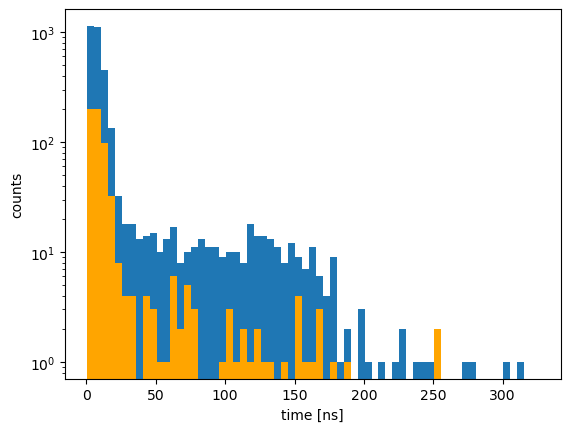

In [685]:

good_t_arr=[]
time_diff=[]
back_to_back_times=[] #inserirò i tempi degli eventi back to back
treshold=-0.018 #soglia fissa
btb_pairs=[np.array([4,5]), np.array([6, 7]), np.array([8, 9]), np.array([10,11]), np.array([12, 13]), np.array([14, 15])]


arr_times_all=times_from_waveforms(true_waveforms,20, treshold)
for ev in range(Nev):
    #trovo il leading edge del gamma da 1200
    index_1200=true_charges[ev].index(max(true_charges[ev]))
    ch_1200=true_channels[ev][index_1200] #trova il canale che ha visto la carica più alta
    t_arr=arr_times_all[ev] #calcolo tempi di arrivo dei segnali
    ev_is_good=[t_arr[i] >= t_arr[index_1200] and t_arr[index_1200]!=0  for i in range(len(true_channels[ev]))]
    if(all(ev_is_good)):
        good_t_arr.append(t_arr)
        t_diff=[t_arr[i] - t_arr[index_1200] for i in range(len(t_arr))]
        #add offset
        #t_diff = [t_diff[i] - matrix_loaded[true_channels[ev][i]][true_channels[ev][index_1200]] for i in range(len(t_diff))]

        t_diff.pop(index_1200)
        time_diff.append(t_diff)
    #print(true_channels[ev])
    gamma_channels = [ch for i, ch in enumerate(true_channels[ev]) if i != index_1200] #canali che hanno visto i fotoncini di annichilazione
    #print(gamma_channels)
    for pair in btb_pairs:
        if np.array_equal(sorted(gamma_channels), sorted(pair)):
            back_to_back_times.append(t_diff)
            break  # Exit loop if a match is found

    
        

#print(time_diff)
mean_time_diff=[np.mean(np.array(times)) for times in time_diff if np.mean(np.array(times))>0]
mean_time_diff=np.array(mean_time_diff)

btb_mean_time_diff =[np.mean(np.array(times)) for times in back_to_back_times]
btb_mean_time_diff = np.array(btb_mean_time_diff)

bins_array = np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=5) # uncomment to go back to even bins

outofwindow=np.where(mean_time_diff > 0.468*1024)[0]
print(outofwindow)



bin_T, edgesT, _=plt.hist(mean_time_diff, bins=bins_array)
_=plt.hist(btb_mean_time_diff, bins=bins_array, color='orange')
plt.yscale('log')

#pop away the first bin
bin_T=bin_T[1:-1]
edgesT=edgesT[1:-1]  #l'ultimo bin eccede la finestra di wavecatcher


#Nbins = len(np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=4))
Nbin=len(bin_T)


centersT = np.convolve(edgesT, [0.5, 0.5], "valid")
#plt.yscale('log')
#plt.xlim(0, 200)
plt.xlabel('time [ns]')
plt.ylabel('counts')
print(np.max(edgesT))
#evaluate errors

errT = np.sqrt(bin_T)
#print(edgesT)

In [686]:
#proviamo a fittare
import lmfit
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [687]:
exp1   = ExponentialModel(prefix='e1_')
exp2   = ExponentialModel(prefix='e2_')

model = exp1 + exp2

params = exp1.guess(bin_T, x=centersT)  
params.update(exp2.guess(bin_T, x=centersT)) 
params["e1_amplitude"].min = 0
params["e2_amplitude"].min = 0
params["e1_decay"].set(value=142)

result = model.fit(bin_T, params, x = centersT, weights = 1 / errT,nan_policy='omit')

print(result.fit_report())

[[Model]]
    (Model(exponential, prefix='e1_') + Model(exponential, prefix='e2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 50
    # variables        = 4
    chi-square         = 96.4578880
    reduced chi-square = 2.09691061
    Akaike info crit   = 40.8541757
    Bayesian info crit = 48.5022677
    R-squared          = 0.99993025
[[Variables]]
    e1_amplitude:  22.0918311 +/- 3.67967704 (16.66%) (init = 61412.63)
    e1_decay:      96.5122736 +/- 12.3521630 (12.80%) (init = 142)
    e2_amplitude:  7487.05334 +/- 837.738129 (11.19%) (init = 61412.63)
    e2_decay:      4.23661968 +/- 0.19827552 (4.68%) (init = 9.827573)
[[Correlations]] (unreported correlations are < 0.100)
    C(e2_amplitude, e2_decay)     = -0.9424
    C(e1_amplitude, e1_decay)     = -0.8427
    C(e1_amplitude, e2_decay)     = -0.3929
    C(e1_amplitude, e2_amplitude) = +0.3120
    C(e1_decay, e2_decay)         = +0.3029
    C(e1_decay, e2_amplitude) 

/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_65843/2885440731.py:12: RuntimeWarning: divide by zero encountered in divide
  result = model.fit(bin_T, params, x = centersT, weights = 1 / errT,nan_policy='omit')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_65843/1139030936.py:22: RuntimeWarning: divide by zero encountered in divide
  norm_resT = residueT / errT


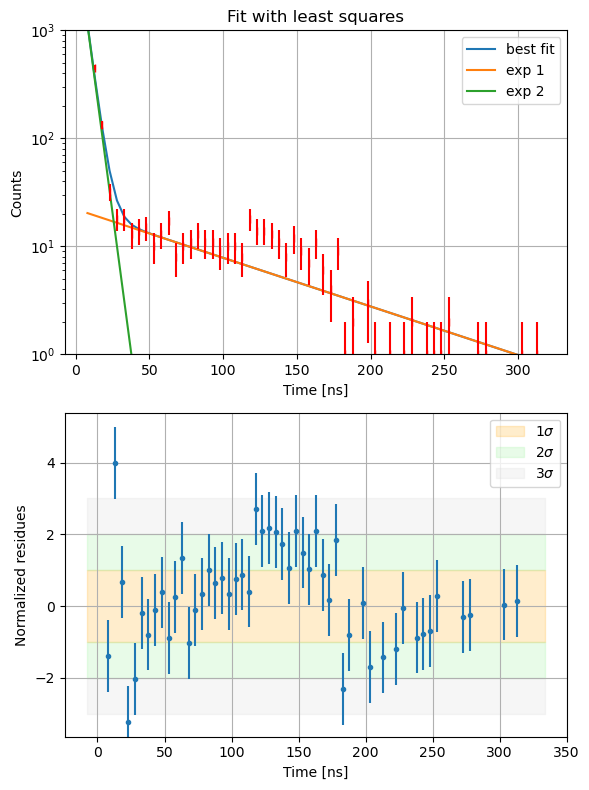

In [688]:
#plot del fit

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersT, result.best_fit, label='best fit')
ax1.plot(centersT, comps['e1_'], label='exp 1')
ax1.plot(centersT, comps['e2_'], label='exp 2')


ax1.legend()
ax1.errorbar(centersT, bin_T, errT, color = "red", fmt='|')
#ax1.set_xlim(0, 200)
ax1.grid()

residueT = bin_T - result.best_fit
norm_resT = residueT / errT

ax2.errorbar(centersT, norm_resT, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
ax1.set_yscale('log')
ax2.legend()
ax1.set_ylim(1, 1000)
ax1.set_title('Fit with least squares')
fig.tight_layout()
plt.show()

In [689]:
emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee = model.fit(data=bin_T, x=centersT, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

/Users/elenadesantis/anaconda3/envs/myrootenv_new/lib/python3.8/site-packages/lmfit/minimizer.py:1092: RuntimeWarning: overflow encountered in square
  lnprob = -0.5 * np.sum((lnprob / np.exp(__lnsigma)) ** 2 + c)
/Users/elenadesantis/anaconda3/envs/myrootenv_new/lib/python3.8/site-packages/lmfit/lineshapes.py:492: RuntimeWarning: overflow encountered in exp
  return amplitude * exp(-x/decay)
/Users/elenadesantis/anaconda3/envs/myrootenv_new/lib/python3.8/site-packages/lmfit/lineshapes.py:492: RuntimeWarning: overflow encountered in multiply
  return amplitude * exp(-x/decay)


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [119.09513963 144.40322215  98.14314125 100.06132379 119.3652868 ]


In [690]:
print(result_emcee.fit_report())

[[Model]]
    (Model(exponential, prefix='e1_') + Model(exponential, prefix='e2_'))
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 63
    # variables        = 5
    chi-square         = 1045.18520
    reduced chi-square = 18.0204344
    Akaike info crit   = 186.955322
    Bayesian info crit = 197.670996
    R-squared          = 0.99924426
[[Variables]]
    e1_amplitude:  12.1152623 +/- 0.85160890 (7.03%) (init = 22.09183)
    e1_decay:      198.050907 +/- 19.6078456 (9.90%) (init = 96.51227)
    e2_amplitude:  5476.42064 +/- 40.6910944 (0.74%) (init = 7487.053)
    e2_decay:      4.99220335 +/- 0.02139971 (0.43%) (init = 4.23662)
    __lnsigma:     0.69243044 +/- 8.6162e-04 (0.12%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(e2_amplitude, e2_decay)     = -0.9945
    C(e1_amplitude, __lnsigma)    = -0.9912
    C(e2_decay, __lnsigma)        = -0.9228
    C(e2_amplitude, __lnsigma)    = +0.9150

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_65843/3949174769.py:20: RuntimeWarning: divide by zero encountered in divide
  norm_resT = residueT / errT


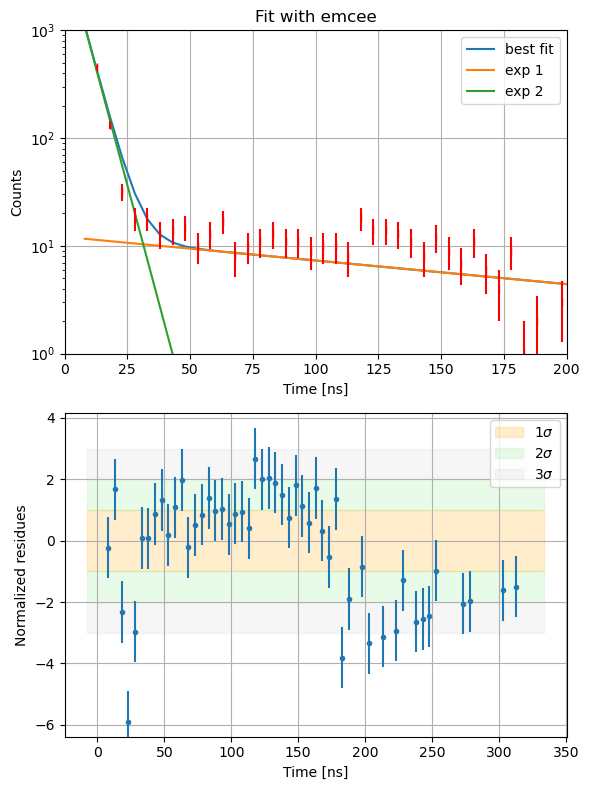

In [691]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result_emcee.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersT, result_emcee.best_fit, label='best fit')
ax1.plot(centersT, comps['e1_'], label='exp 1')
ax1.plot(centersT, comps['e2_'], label='exp 2')


ax1.legend()
ax1.errorbar(centersT, bin_T, errT, color = "red", fmt='|')
ax1.set_xlim(0, 200)
ax1.grid()

residueT = bin_T - result_emcee.best_fit
norm_resT = residueT / errT

ax2.errorbar(centersT, norm_resT, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
ax1.set_yscale('log')
ax2.legend()
ax1.set_ylim(1, 1000)
ax1.set_title('Fit with emcee')
fig.tight_layout()
plt.show()

0.0
[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 30
    # variables        = 2
    chi-square         = 57.4636814
    reduced chi-square = 2.05227434
    Akaike info crit   = 23.4986722
    Bayesian info crit = 26.3010669
    R-squared          = 0.99879765
[[Variables]]
    e1_amplitude:  928.755228 +/- 175.467103 (18.89%) (init = 103.9727)
    e1_decay:      5.32328403 +/- 0.43746139 (8.22%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(e1_amplitude, e1_decay) = -0.9111


/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_65843/3024730499.py:23: RuntimeWarning: divide by zero encountered in divide
  result = model.fit(bin_btb, params, x = centers_btb, weights = 1 / err_btb,nan_policy='omit')


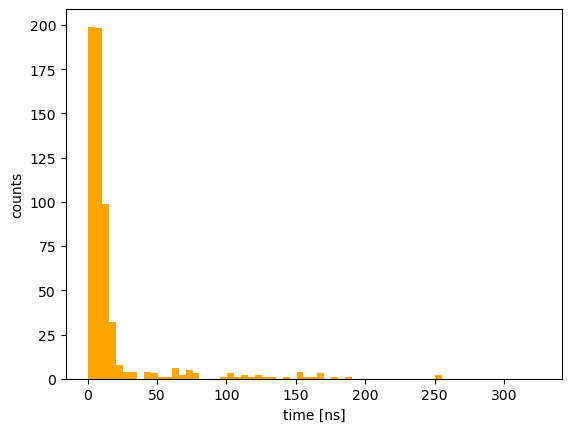

In [692]:
#fitto solo la componente back to back

bin_btb, edges_btb, _=plt.hist(btb_mean_time_diff, bins=bins_array, color='orange')

print(np.min(btb_mean_time_diff))

bin_btb=bin_btb[1:-1]
edges_btb=edges_btb[1:-1]  

centers_btb = np.convolve(edges_btb, [0.5, 0.5], "valid")
plt.xlabel('time [ns]')
plt.ylabel('counts')
err_btb = np.sqrt(bin_btb)

exp1   = ExponentialModel(prefix='e1_')

model = exp1 

params = exp1.guess(bin_btb, x=centers_btb)  
params["e1_amplitude"].min = 0
params["e1_decay"].set(value=4)

result = model.fit(bin_btb, params, x = centers_btb, weights = 1 / err_btb,nan_policy='omit')

print(result.fit_report())

emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee_btb = model.fit(data=bin_btb, x=centers_btb, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

In [693]:
print(result_emcee_btb.fit_report())

[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 63
    # variables        = 3
    chi-square         = 106.948659
    reduced chi-square = 1.78247765
    Akaike info crit   = 39.3404927
    Bayesian info crit = 45.7698969
    R-squared          = 0.99776225
[[Variables]]
    e1_amplitude:  757.232755 +/- 22.7645355 (3.01%) (init = 928.7552)
    e1_decay:      6.02951703 +/- 0.11399887 (1.89%) (init = 5.323284)
    __lnsigma:     0.67830197 +/- 0.01713578 (2.53%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(e1_amplitude, e1_decay)  = -0.9639
    C(e1_amplitude, __lnsigma) = -0.2151
    C(e1_decay, __lnsigma)     = +0.2038


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_65843/2246015805.py:18: RuntimeWarning: divide by zero encountered in divide
  norm_res_btb = residue_btb / err_btb


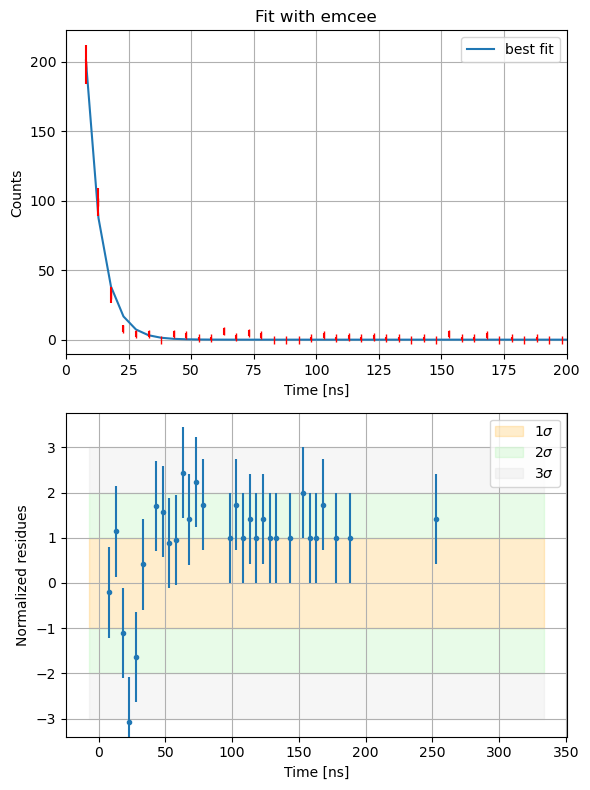

In [694]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

#comps = result_emcee.eval_components()                       
ax1.plot(centers_btb, result_emcee_btb.best_fit, label='best fit')


ax1.legend()
ax1.errorbar(centers_btb, bin_btb, err_btb, color = "red", fmt='|')
ax1.set_xlim(0, 200)
ax1.grid()

residue_btb = bin_btb - result_emcee_btb.best_fit
norm_res_btb = residue_btb / err_btb

ax2.errorbar(centers_btb, norm_res_btb, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
#ax1.set_ylim(1, 1000)
ax1.set_title('Fit with emcee')
fig.tight_layout()

[24. 14. 14. 13. 10. 12.  9. 12. 11.  6.  5.  8. 13. 11. 11.  8.  7.  9.
  6. 17. 12. 13. 12. 11.  7. 12.  5.  6. 10.  3.  4.  8.  1.  1.  0.  3.
  1.  0.  1.  0.  1.  2.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  1.  0.  1.  0.] [ 20.5  25.5  30.5  35.5  40.5  45.5  50.5  55.5  60.5  65.5  70.5  75.5
  80.5  85.5  90.5  95.5 100.5 105.5 110.5 115.5 120.5 125.5 130.5 135.5
 140.5 145.5 150.5 155.5 160.5 165.5 170.5 175.5 180.5 185.5 190.5 195.5
 200.5 205.5 210.5 215.5 220.5 225.5 230.5 235.5 240.5 245.5 250.5 255.5
 260.5 265.5 270.5 275.5 280.5 285.5 290.5 295.5 300.5 305.5 310.5 315.5
 320.5]
[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 46
    # variables        = 2
    chi-square         = 64.4392792
    reduced chi-square = 1.46452907
    Akaike info crit   = 19.5057709
    Bayesian info crit = 23.1630537
    R-squared          = 0.96610837
[[Variables]]
    e1

/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_65843/600143205.py:21: RuntimeWarning: divide by zero encountered in divide
  result = model.fit(three_gamma_ortho, params, x = three_gamma_centers, weights = 1 / three_g_err,nan_policy='omit')


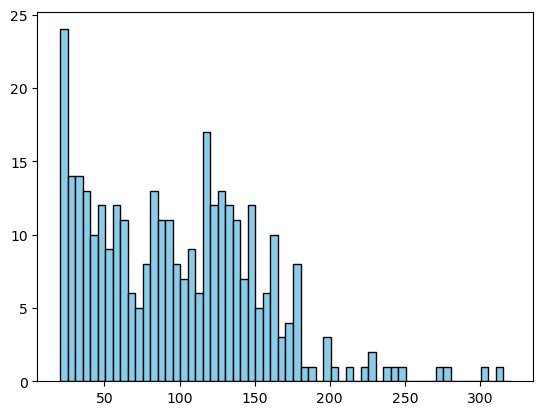

In [695]:
#isolo la componente a 3 fotoni

three_gamma_ortho=bin_T - bin_btb
three_gamma_edges=edgesT

three_gamma_ortho = three_gamma_ortho[3:]
three_gamma_edges = three_gamma_edges[3:]

print(three_gamma_ortho, three_gamma_edges)
three_gamma_centers = np.convolve(three_gamma_edges, [0.5, 0.5], "valid")
three_g_err=np.sqrt(three_gamma_ortho)
plt.bar(three_gamma_edges[:-1], three_gamma_ortho, width=(three_gamma_edges[1] - three_gamma_edges[0]),align='edge', color='skyblue', edgecolor='black')

exp1   = ExponentialModel(prefix='e1_')

model = exp1 

params = exp1.guess(three_gamma_ortho, x=three_gamma_centers)  
params["e1_amplitude"].min = 0

result = model.fit(three_gamma_ortho, params, x = three_gamma_centers, weights = 1 / three_g_err,nan_policy='omit')

print(result.fit_report())

emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee_3g = model.fit(data=three_gamma_ortho, x=three_gamma_centers, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)


In [696]:
print(result_emcee_3g.fit_report())

[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 60
    # variables        = 3
    chi-square         = 151.835428
    reduced chi-square = 2.66377944
    Akaike info crit   = 61.7071598
    Bayesian info crit = 67.9901935
    R-squared          = 0.92014266
[[Variables]]
    e1_amplitude:  20.4421599 +/- 1.19186192 (5.83%) (init = 21.01921)
    e1_decay:      111.697814 +/- 7.79116701 (6.98%) (init = 90.77832)
    __lnsigma:     0.68598417 +/- 0.00839466 (1.22%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(e1_amplitude, e1_decay) = -0.7984


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_65843/326572571.py:18: RuntimeWarning: divide by zero encountered in divide
  norm_res_3g = residue_3g / three_g_err


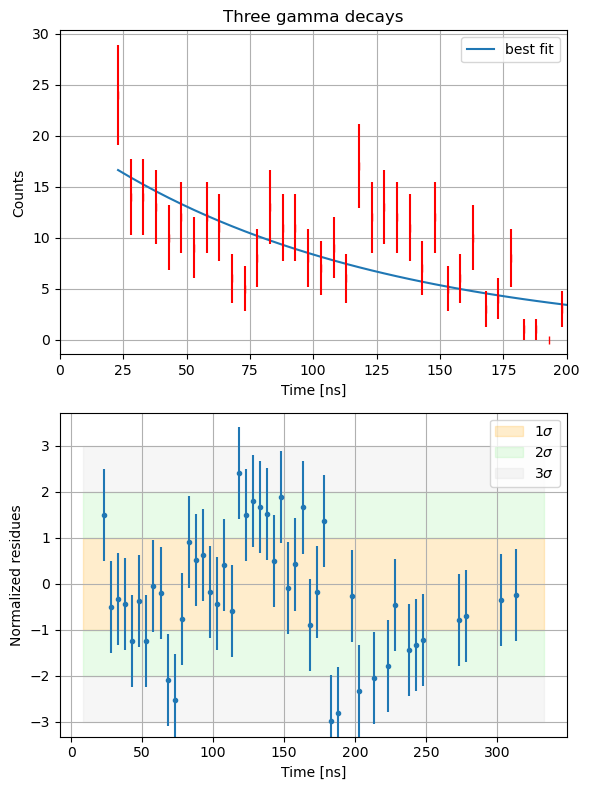

In [697]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

#comps = result_emcee.eval_components()                       
ax1.plot(three_gamma_centers, result_emcee_3g.best_fit, label='best fit')


ax1.legend()
ax1.errorbar(three_gamma_centers, three_gamma_ortho, three_g_err, color = "red", fmt='|')
ax1.set_xlim(0, 200)
ax1.grid()

residue_3g = three_gamma_ortho - result_emcee_3g.best_fit
norm_res_3g = residue_3g / three_g_err

ax2.errorbar(three_gamma_centers, norm_res_3g, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
#ax1.set_ylim(1, 1000)
ax1.set_title('Three gamma decays')
fig.tight_layout()

# Un po' di speculazioni da strutturista secondo il modello di Tao-Eldrup

In [698]:
delta = 0.166 #nm
lambdabar = 2.01 #ns^-1
lambda_po= 1/result_emcee_btb.params["e1_decay"].value #ns^-1
tau_po = result_emcee_btb.params["e1_decay"].value #ns
Rc = (tau_po + 5.07)/1.88
print(Rc)

5.903998421574133
